# Calibrate HPF LFC Profiles

The resolution seems off.  Let's calibrate blasé with the LFC spectra.

In [1]:
import torch
from blase.emulator import SparseLogEmulator, ExtrinsicModel, InstrumentalModel
import matplotlib.pyplot as plt
from blase.utils import doppler_grid
import astropy.units as u
import numpy as np
from specutils import Spectrum1D
from muler.hpf import HPFSpectrum
import seaborn as sns
import os
import pandas as pd

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

Woohoo! You have a version 1.11.0+cu102 of PyTorch


## Get Real data with unknown signals

In [2]:
fn = '002_goldilocks_CALS_54235x20_v1p1.csv'

df = pd.read_csv('../../data/tables/'+fn)

In [3]:
mask = df.OBJECT.str.contains('LFC Cal')

In [4]:
mask.sum()

13357

In [5]:
df = df[mask].reset_index(drop=True)

In [6]:
root_path = '../../data/HPF/demo/'

In [7]:
df.file_basename

0        Goldilocks_20181004T124436_v1.0_0036.spectra.fits
1        Goldilocks_20181004T124711_v1.0_0037.spectra.fits
2        Goldilocks_20181004T232259_v1.0_0056.spectra.fits
3        Goldilocks_20181004T232528_v1.0_0057.spectra.fits
4        Goldilocks_20181008T130755_v1.0_0035.spectra.fits
                               ...                        
13352    Goldilocks_20230515T095316_v1.0_0038.spectra.fits
13353    Goldilocks_20230515T095534_v1.0_0039.spectra.fits
13354    Goldilocks_20230515T095753_v1.0_0040.spectra.fits
13355    Goldilocks_20230515T112156_v1.0_0059.spectra.fits
13356    Goldilocks_20230515T112414_v1.0_0060.spectra.fits
Name: file_basename, Length: 13357, dtype: object

In [8]:
rand_i = np.random.randint(0, 12_000, 5)

In [9]:
df.iloc[rand_i].file_basename.values

array(['Goldilocks_20200522T120707_v1.0_0044.spectra.fits',
       'Goldilocks_20210210T101100_v1.0_0021.spectra.fits',
       'Goldilocks_20221209T124009_v1.0_0045.spectra.fits',
       'Goldilocks_20220206T005958_v1.0_0004.spectra.fits',
       'Goldilocks_20230225T055547_v1.0_0005.spectra.fits'], dtype=object)

In [10]:
file='junk'

In [11]:
if not os.path.exists(file):
    file = '../../data/HPF/demo/Goldilocks_20220329T090917_v1.0_0013.spectra.fits'

## Derive a relationship for laser modes

Lets use the entire bandwidth.

In [12]:
from muler.hpf import HPFSpectrumList

In [13]:
spec_list = HPFSpectrumList.read(file)

In [14]:
spec_list = HPFSpectrumList([spec.lfc for spec in spec_list])

<AxesSubplot:title={'center':'HPF Spectrum'}, xlabel='$\\lambda \\;(\\AA)$', ylabel='Flux'>

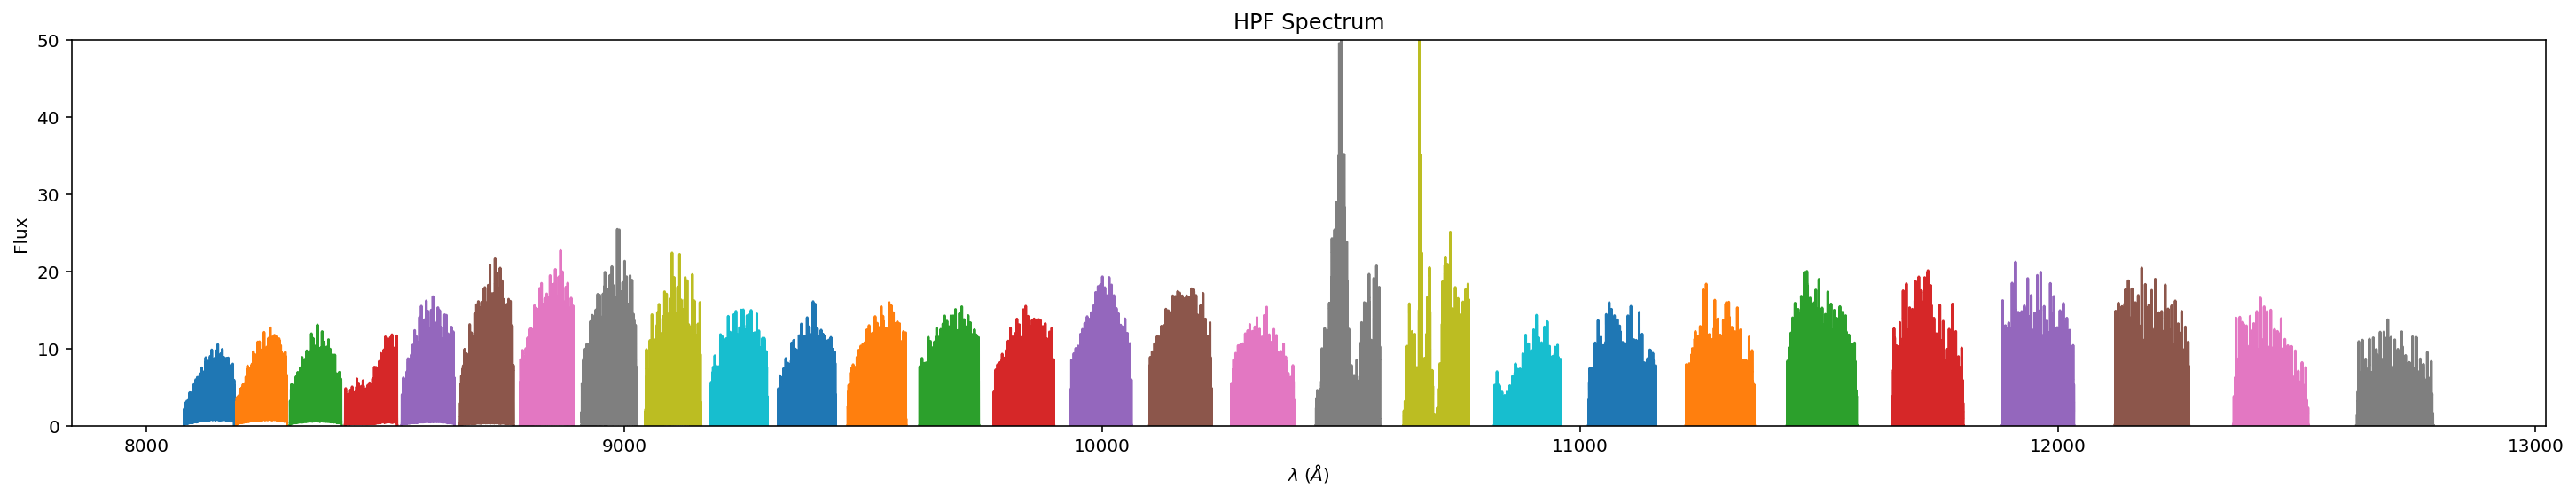

In [15]:
spec_list.normalize().plot(yhi=50)

In [16]:
spec = spec_list.normalize().stitch()#HPFSpectrum(file=file, order=19)

<AxesSubplot:title={'center':'HPF Spectrum'}, xlabel='$\\lambda \\;(\\AA)$', ylabel='Flux'>

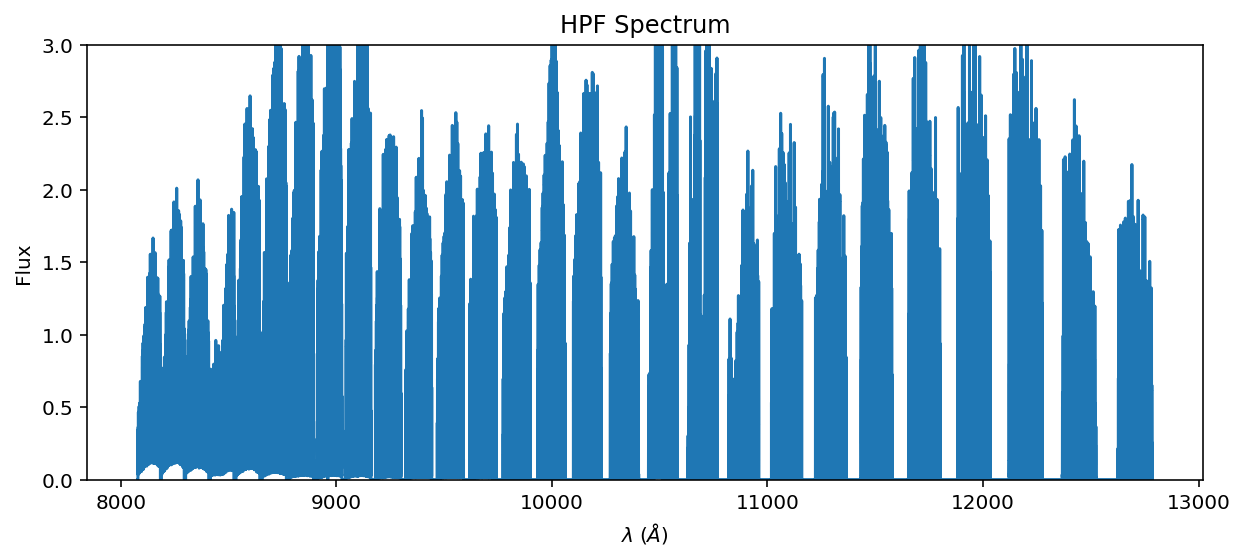

In [17]:
scalar = np.percentile(spec.flux, 90)
spec = spec.divide(scalar, handle_meta='ff')

spec_orig = spec._copy()

spec.plot(ylo=0, yhi=3)

In [18]:
spec.meta['header']['OBJECT']

'LFC Cal'

In [19]:
spectrum = spec

In [20]:
spectrum.bin_edges

<Quantity [ 8078.99592256,  8079.05541439,  8079.11490256, ...,
           12785.72280169, 12785.78776702, 12785.85272511] Angstrom>

In [21]:
guess_sigma = 0.01
guess_gamma = 0.07

## Pre-process the data
We will quickly pre-process the HPF spectrum with the [muler](https://muler.readthedocs.io/en/latest/) library

In [22]:
from scipy.signal import find_peaks

In [23]:
import astropy.constants as const

In [24]:
def predict_lfc_peaks(spec, spacing=30.0, lam0=None):
    peaks, properties = find_peaks(spec_orig.flux.value, distance=10, prominence=0.01)
    peak_coords = spec_orig.wavelength.value[peaks]
    peak_freqs = spec_orig.frequency.value[peaks] # GHz
    
    if lam0 is None:
        freq0 = peak_freqs[0]
    else:
        freq0 = (const.c/(lam0*u.Angstrom)).to(u.GHz).value
    pred_freqs = np.arange(freq0, spec.frequency.min().value, -1*spacing)
    
    #censor to just the visible peaks:
    distance_matrix = np.abs(pred_freqs[:, np.newaxis] - peak_freqs)
    pred_inds = distance_matrix.argmin(axis=0)
    
    return pred_freqs[pred_inds], peak_coords

In [25]:
lam_guess = 8079.525

In [26]:
peak_frequencies, peak_coords = predict_lfc_peaks(spec, lam0=lam_guess)

In [27]:
peak_wavelengths = (const.c/(peak_frequencies*u.GHz)).to(u.Angstrom).value

Yay, we have a way to generate our guesses for the peaks:

In [28]:
%matplotlib inline

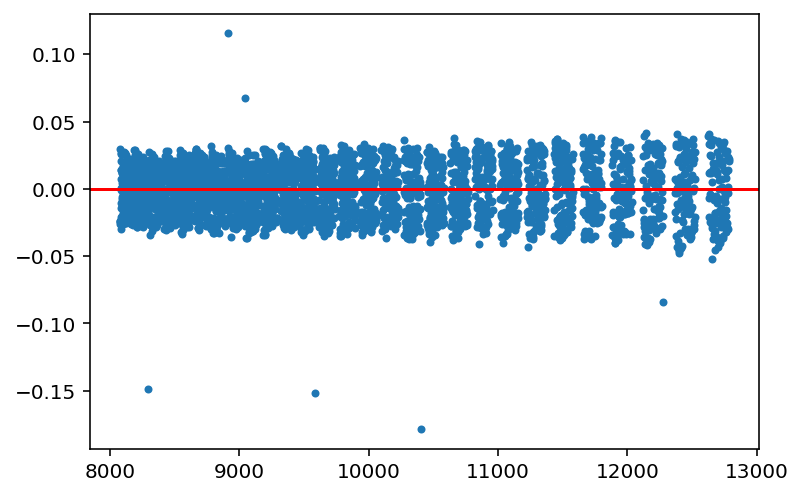

In [29]:
plt.plot(peak_wavelengths, peak_coords-peak_wavelengths, '.')
plt.axhline(0.0, color='r')

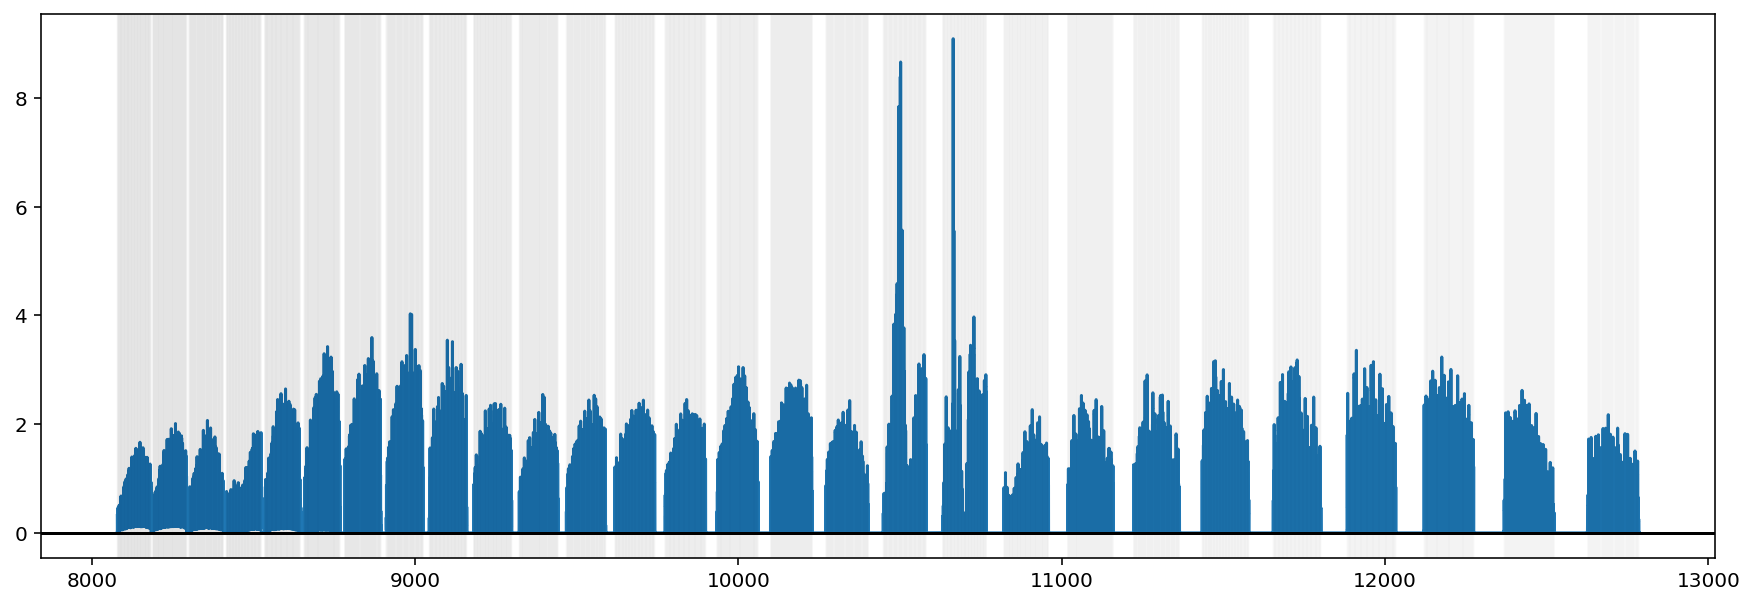

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))

plt.step(spectrum.wavelength, spectrum.flux, where='mid')

for xv in peak_wavelengths:
    ax.axvline(xv, linestyle='solid', alpha=0.05, color='k', lw=0.2)
    
ax.axhline(0.0, color='k');

We have detected all the spectral lines

In [31]:
wl_lo = spectrum.wavelength.min().value-30.0
wl_hi = spectrum.wavelength.max().value+30.0
wavelength_grid = doppler_grid(wl_lo, wl_hi)

## Model the lines with blasé

In [32]:
from blase.emulator import SparseLogEmissionEmulator

In [33]:
from collections import OrderedDict

In [34]:
peak_wavelengths = torch.from_numpy(peak_wavelengths)
guess_amps = 0.2*torch.ones_like(peak_wavelengths)

In [35]:
n_lines = len(peak_wavelengths)

In [36]:
state_dict = OrderedDict({'lam_centers':peak_wavelengths,
                  'amplitudes':torch.log(guess_amps), 
                  'sigma_widths':torch.log(torch.repeat_interleave(torch.tensor(guess_sigma), n_lines)), 
                  'gamma_widths':torch.log(torch.repeat_interleave(torch.tensor(guess_gamma), n_lines)),
                  'a_coeff':torch.tensor(1.0), 
                  'b_coeff':torch.tensor(0.0),
                  'c_coeff':torch.tensor(0.0), 
                  'radial_velocity':torch.tensor(0.0)})

### Guess and check

In [37]:
emission_model = SparseLogEmissionEmulator(wavelength_grid, 
                                     init_state_dict=state_dict, wing_cut_pixels=100, device=device)
emission_model.to(device)

Initializing a sparse model with 3605 spectral lines


SparseLogEmissionEmulator()

In [38]:
with torch.no_grad():
    emission_spec = emission_model.forward().cpu().numpy()

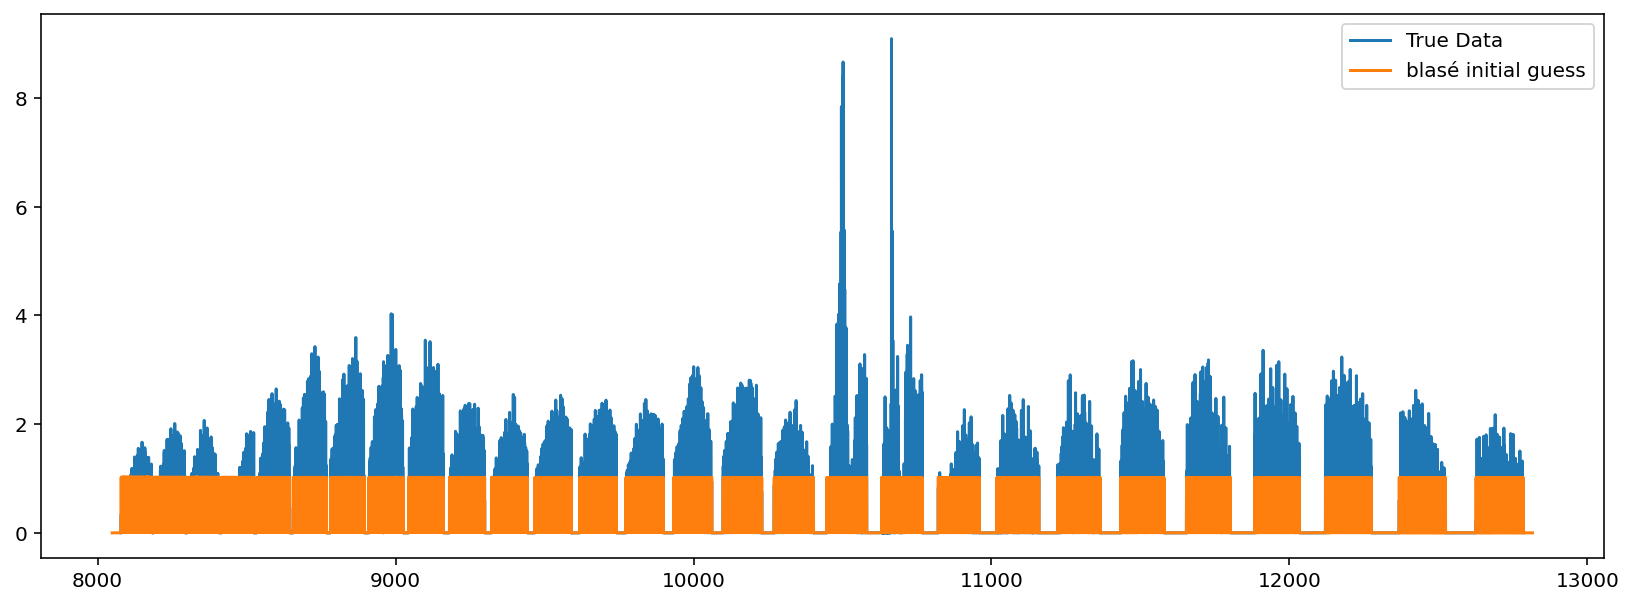

In [39]:
plt.figure(figsize=(14, 5))
plt.step(spectrum.wavelength, spectrum.flux, where='mid', label='True Data')
plt.step(wavelength_grid, emission_spec, where='mid', label='blasé initial guess')
#plt.xlim(10820, 10850)
plt.legend();

#### Instrumental model

In [40]:
instrumental_model = InstrumentalModel(spectrum.bin_edges.value, wavelength_grid, device=device)
instrumental_model.to(device)

InstrumentalModel(
  (linear_model): Linear(in_features=15, out_features=1, bias=True)
)

In [41]:
#instrumental_model.ln_sigma_angs.data = torch.log(torch.tensor(0.064))

## Transfer learn a semi-empirical model

Here we compare the resampled joint model to the observed data to "transfer learn" underlying super resolution spectra.

In [42]:
from torch import nn
from tqdm import trange
import torch.optim as optim

In [43]:
data_target = torch.tensor(
    spectrum.flux.value.astype(np.float64), device=device, dtype=torch.float64
)

data_wavelength = torch.tensor(
    spectrum.wavelength.value.astype(np.float64), device=device, dtype=torch.float64
)

In [44]:
loss_fn = nn.MSELoss(reduction="mean")

### Fix certain parameters, allow others to vary
As we have seen before, you can fix parameters by "turning off their gradients".  We will start by turning off *ALL* gradients.  Then turn on some.

In [45]:
# Fix all stellar parameters except amplitude and RV
emission_model.amplitudes.requires_grad = True
emission_model.radial_velocity.requires_grad = False
emission_model.lam_centers.requires_grad = False
emission_model.sigma_widths.requires_grad = True
emission_model.gamma_widths.requires_grad = True
emission_model.a_coeff.requires_grad = False
emission_model.b_coeff.requires_grad = False
emission_model.c_coeff.requires_grad = False

# Fix all instrument parameters
instrumental_model.ln_sigma_angs.requires_grad = False
instrumental_model.linear_model.weight.requires_grad = False
instrumental_model.linear_model.bias.requires_grad = False

In [46]:
const_term = torch.tensor(0.01, requires_grad=True, device=device)

In [47]:
nk = 31
kernel = torch.zeros(nk, requires_grad=True, dtype=torch.double, device=device)

In [48]:
def modulation_func(lengthscale, modamp1, modamp2, wl):
    '''Never fit phase'''
    sinterm = modamp1 * torch.sin(2.0 * math.pi * wl/lengthscale)
    costerm = modamp2 * torch.cos(2.0 * math.pi * wl/lengthscale)
    return sinterm + costerm

In [49]:
modulation_params = torch.tensor([7.7, 0.1, 0.0], requires_grad=True, dtype=torch.double, device=device)

In [50]:
tuning_params = list(filter(lambda p: p.requires_grad, emission_model.parameters()))\
                + [const_term] \
                + [kernel] \
                + [modulation_params]

In [51]:
tuning_params

[Parameter containing:
 tensor([-1.6094, -1.6094, -1.6094,  ..., -1.6094, -1.6094, -1.6094],
        device='cuda:0', dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([-4.6052, -4.6052, -4.6052,  ..., -4.6052, -4.6052, -4.6052],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-2.6593, -2.6593, -2.6593,  ..., -2.6593, -2.6593, -2.6593],
        device='cuda:0', requires_grad=True),
 tensor(0.0100, device='cuda:0', requires_grad=True),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.], device='cuda:0', dtype=torch.float64,
        requires_grad=True),
 tensor([7.7000, 0.1000, 0.0000], device='cuda:0', dtype=torch.float64,
        requires_grad=True)]

In [52]:
optimizer = optim.Adam(tuning_params,0.05,amsgrad=True)         

In [53]:
n_epochs = 100
losses = []

First, we need to assign uncertainty to the data in order to weigh the prior against new data:

In [54]:
#per_pixel_uncertainty = torch.tensor(0.01, device=device, dtype=torch.float64)

make an adhoc kernel to convolve with

In [55]:
#with torch.no_grad():
#    lhs = emission_model.forward().unsqueeze(0).unsqueeze(1)
#    rhs = kernel#.unsqueeze(0).unsqueeze(1)
#    out = torch.nn.functional.conv1d(lhs, rhs, padding='same').squeeze()

In [56]:
fixed_wl = emission_model.wl_native.to(device)

In [57]:
fixed_wl

tensor([ 8049.0257,  8049.0391,  8049.0525,  ..., 12815.7664, 12815.7877,
        12815.8091], device='cuda:0', dtype=torch.float64)

In [59]:
import math

In [60]:
t_iter = trange(n_epochs, desc="Training", leave=True)
for epoch in t_iter:
    emission_model.train()
    instrumental_model.train()
    
    flux = emission_model.forward()
    lengthscale, modamp1, modamp2 = modulation_params
    modulated_flux = modulation_func(lengthscale, modamp1, modamp2, fixed_wl) + flux
    kernel_term = torch.exp(kernel.unsqueeze(0).unsqueeze(1))
    warped_flux = torch.nn.functional.conv1d(modulated_flux.unsqueeze(0).unsqueeze(1), 
                                             kernel_term/kernel_term.sum(), padding='same').squeeze()
    detector_flux = instrumental_model.resample_to_data(warped_flux)+const_term
    
    loss = loss_fn(detector_flux, data_target)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    t_iter.set_description("Training Loss: {:0.8f}".format(loss.item()))

Training Loss: 0.00149465: 100%|████████████████████████████████████████████████| 100/100 [02:55<00:00,  1.75s/it]


In [61]:
lambda_kernel = torch.cumsum(torch.diff(emission_model.wl_native[5848:5848+nk+1]), 0)
lambda_kernel = lambda_kernel - torch.median(lambda_kernel)
lambda_kernel

tensor([-0.2033, -0.1898, -0.1762, -0.1627, -0.1491, -0.1356, -0.1220, -0.1084,
        -0.0949, -0.0813, -0.0678, -0.0542, -0.0407, -0.0271, -0.0136,  0.0000,
         0.0136,  0.0271,  0.0407,  0.0542,  0.0678,  0.0813,  0.0949,  0.1085,
         0.1220,  0.1356,  0.1491,  0.1627,  0.1762,  0.1898,  0.2033],
       dtype=torch.float64)

Text(0.5, 0, '$\\Delta \\lambda~(\\AA)$')

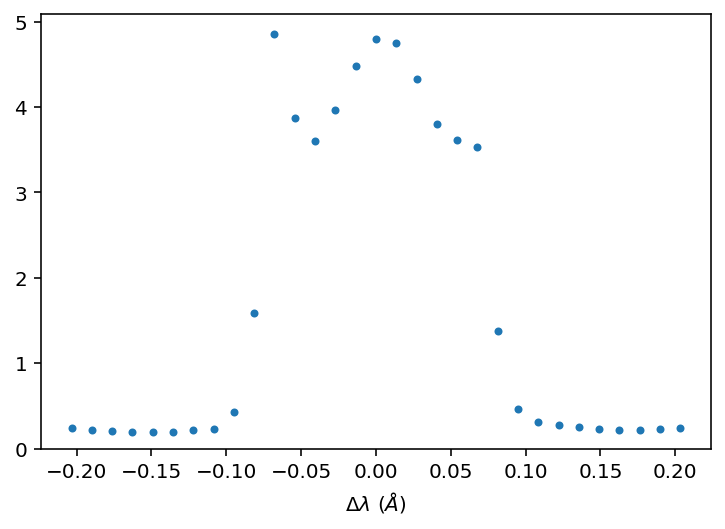

In [62]:
with torch.no_grad():
    plt.plot(lambda_kernel, torch.exp(kernel.detach().cpu()), '.')
plt.ylim(0)
plt.xlabel('$\Delta \lambda~(\AA)$')

### Spot check the transfer-learned joint model

In [63]:
residual = spectrum.flux - detector_flux.detach().cpu().numpy()

In [64]:
%matplotlib notebook

<IPython.core.display.Javascript object>


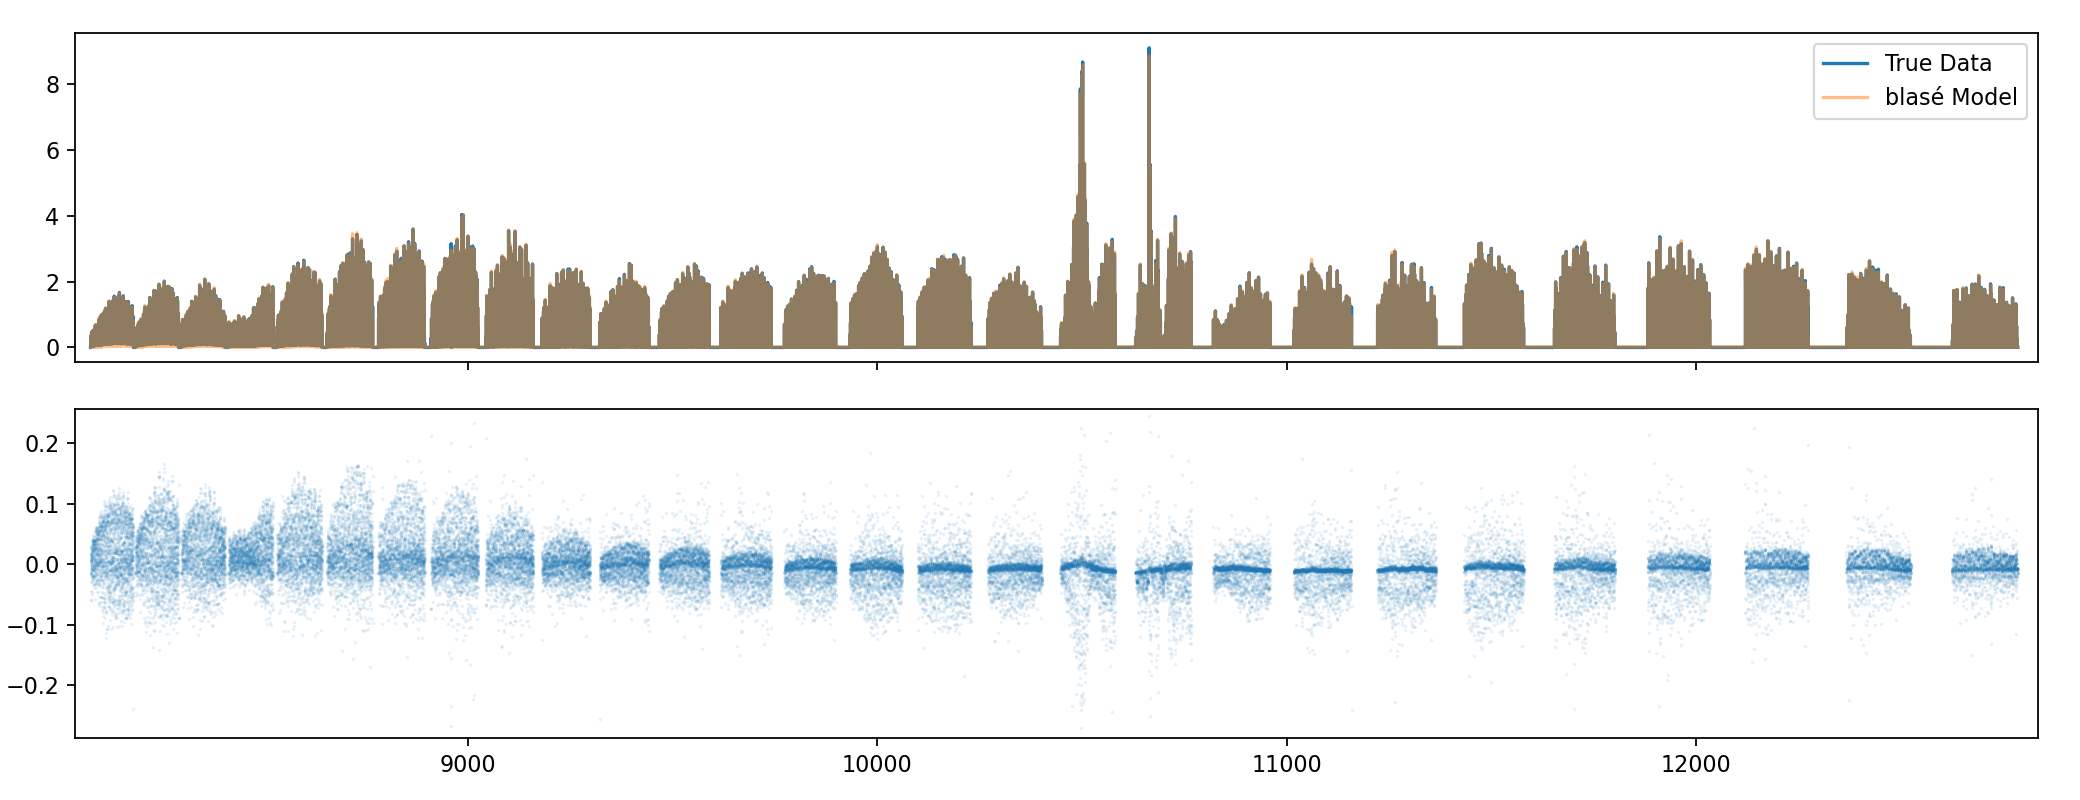

In [65]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(13, 5), sharex=True)
fig.tight_layout()
ax1.step(spectrum.wavelength, spectrum.flux, where='mid', label='True Data');
ax1.step(spectrum.wavelength, detector_flux.detach().cpu().numpy(),where='mid', label='blasé Model', alpha=0.5);
ax2.plot(spectrum.wavelength,residual, '.', ms=1, alpha=0.1)
ax1.legend();

<IPython.core.display.Javascript object>


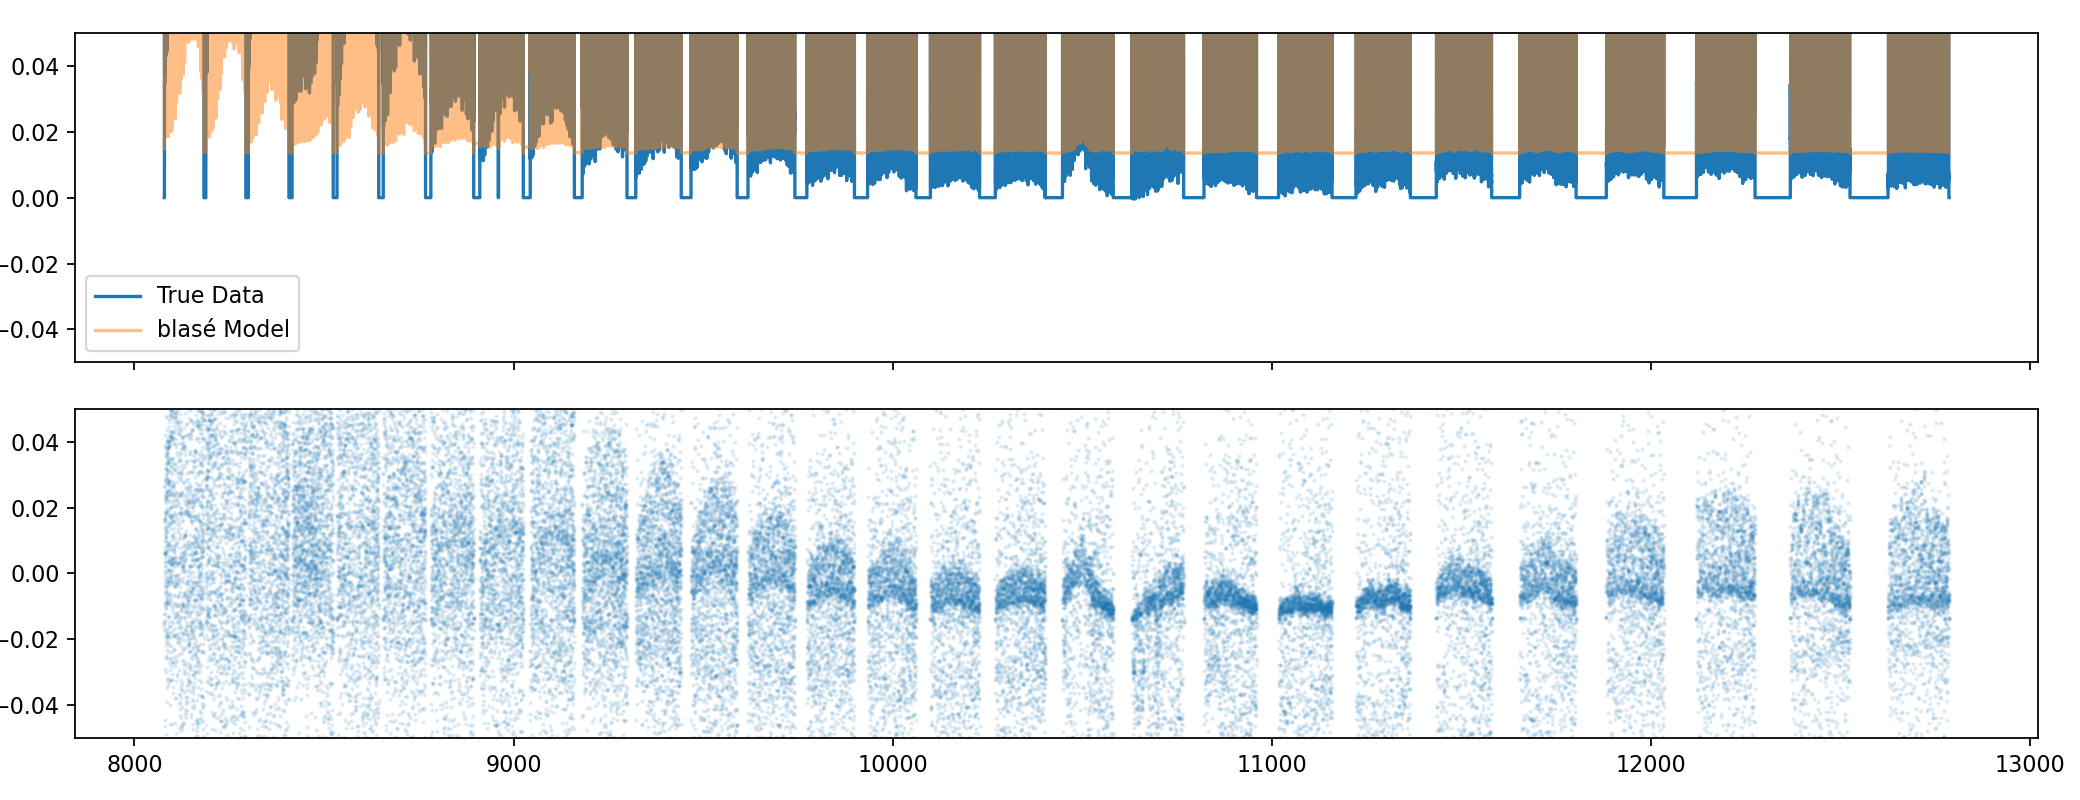

In [66]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(13, 5), sharex=True)
fig.tight_layout()
ax1.step(spectrum.wavelength, spectrum.flux, where='mid', label='True Data');
ax1.step(spectrum.wavelength, detector_flux.detach().cpu().numpy(), label='blasé Model', alpha=0.5);
ax2.plot(spectrum.wavelength,residual,'.', ms=2, alpha=0.1)
ax1.set_ylim(-0.05, 0.05)
ax2.set_ylim(-0.05, 0.05)
ax1.legend();

<IPython.core.display.Javascript object>


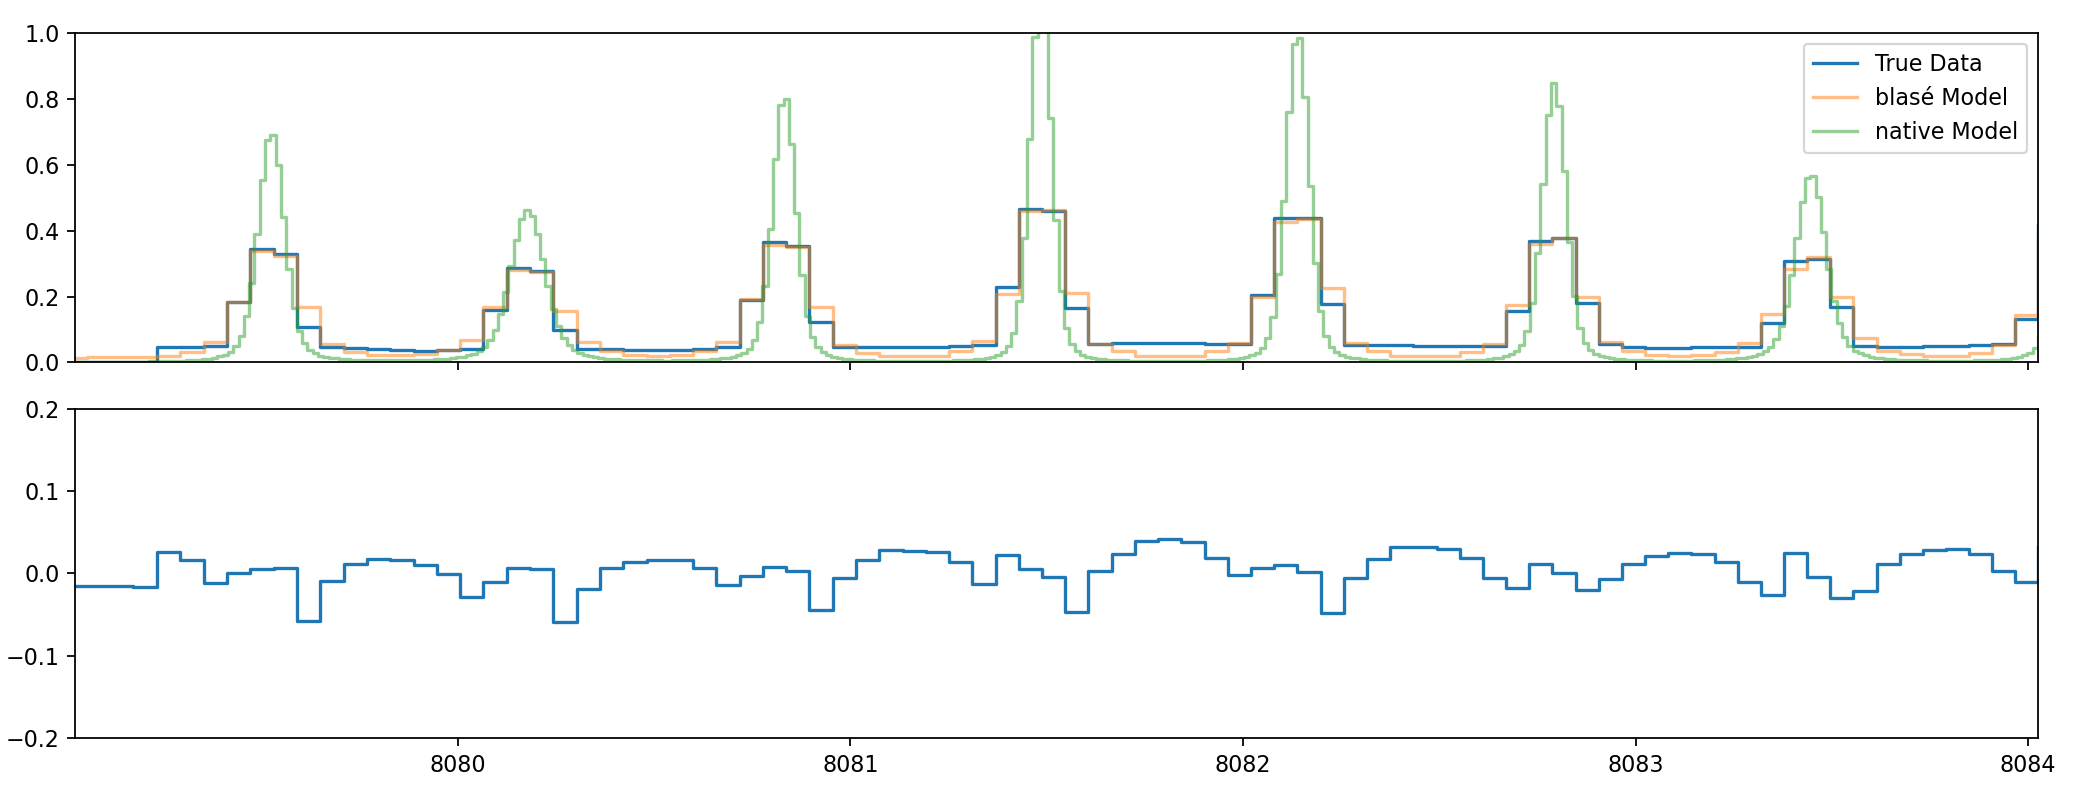

In [67]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(13, 5), sharex=True)
fig.tight_layout()
ax1.step(spectrum.wavelength, spectrum.flux, where='mid', label='True Data');
ax1.step(spectrum.wavelength, detector_flux.detach().cpu().numpy(), label='blasé Model', alpha=0.5, where='mid');
ax2.step(spectrum.wavelength,residual, where='mid')

with torch.no_grad():
    ax1.step(emission_model.wl_native, emission_model.forward().cpu(), label='native Model', alpha=0.5, where='mid');

ax1.set_xlim(spectrum.wavelength.min().value, spectrum.wavelength.min().value+5)
ax2.set_xlim(spectrum.wavelength.min().value, spectrum.wavelength.min().value+5)
ax2.set_ylim(-0.2, 0.2)
ax1.set_ylim(0, 1)
ax1.legend();

Hooray! We match the data pretty well!

In [68]:
np.std(residual)

<Quantity 0.03866012>

<IPython.core.display.Javascript object>


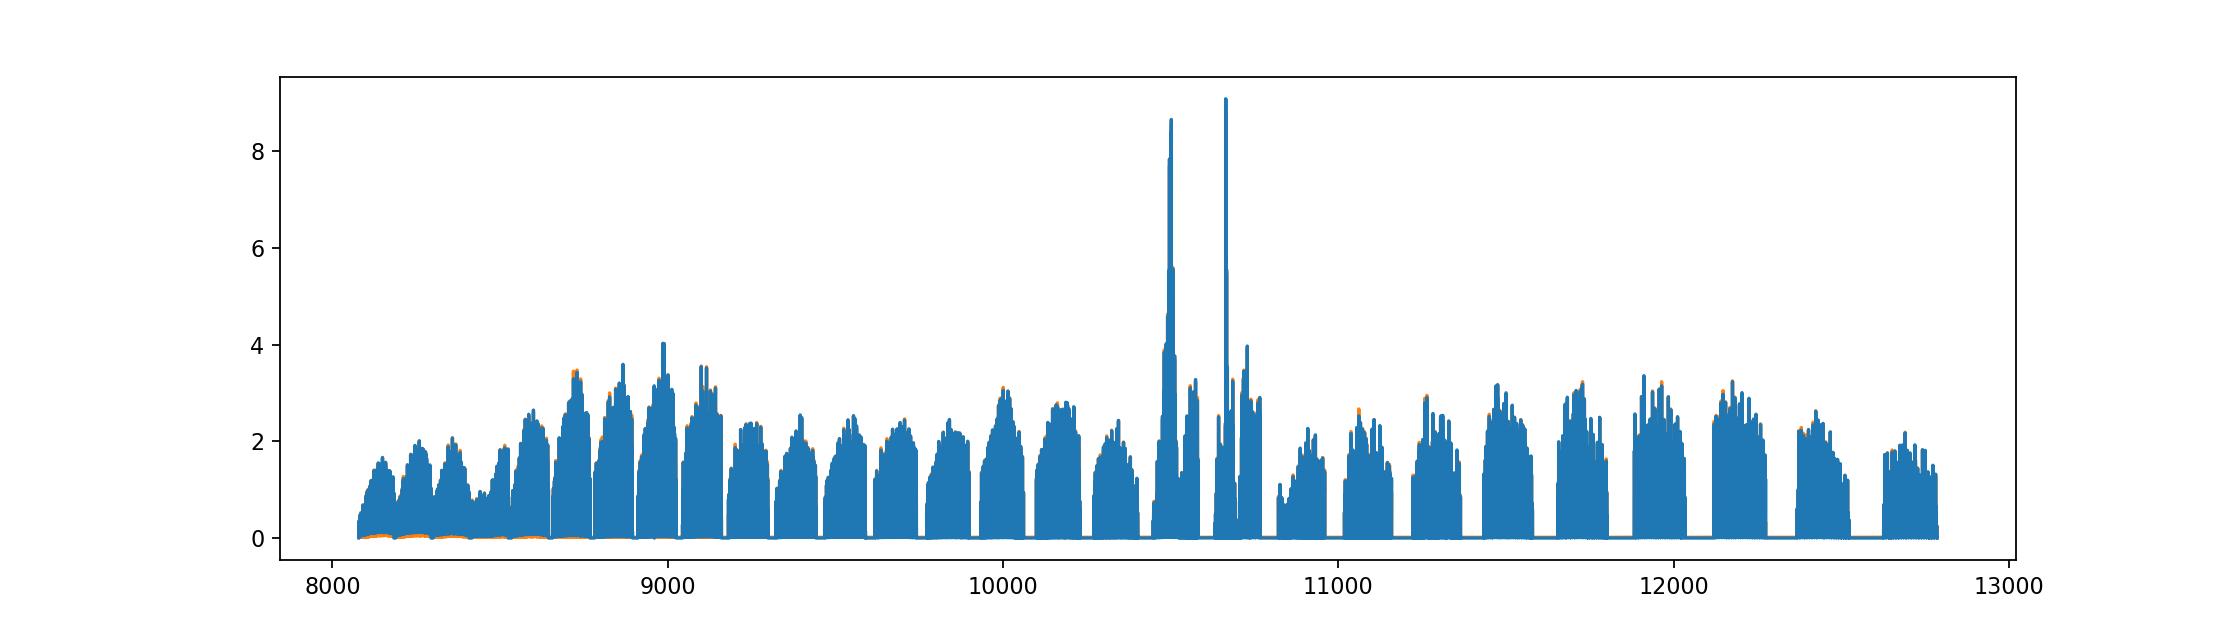

In [69]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.step(spectrum.wavelength, spectrum.flux, where='mid', zorder=11);
ax.step(spectrum.wavelength, detector_flux.detach().cpu().numpy(), where='mid');
#ax.set_xlim(10690, 10710)

Looks great, albeit not perfect-- we are resampling spectra, which should have an effect here...

<IPython.core.display.Javascript object>


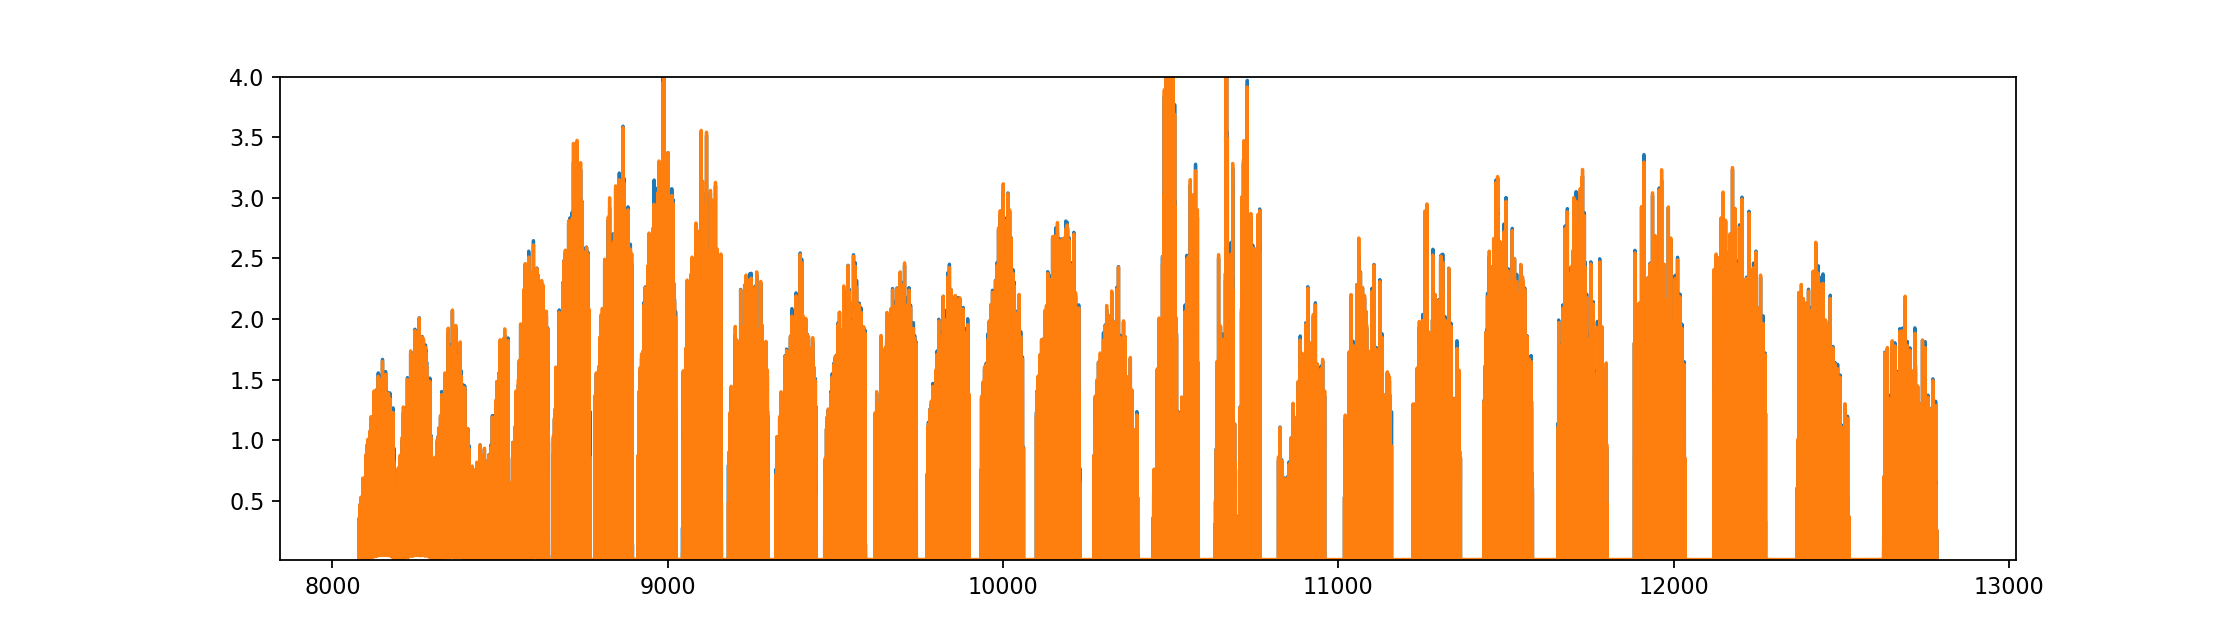

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [70]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.step(spectrum.wavelength, spectrum.flux, where='mid');
ax.step(spectrum.wavelength, detector_flux.detach().cpu().numpy(), where='mid');
#ax.set_xlim(spectrum.wavelength.min().value, spectrum.wavelength.min().value+20)
ax.set_ylim(1e-2, 4)
with torch.no_grad():
    lengthscale, modamp1, modamp2 = modulation_params
    plt.plot(emission_model.wl_native, 
             const_term + modulation_func(lengthscale, modamp1, modamp2, emission_model.wl_native))

ax.plot()
plt.yscale('log')

A ha! Our Voigt profile drops off too quickly--- we need heavier tails!  Something is wrong in our prescription...

### Inspect the individual stellar and telluric components

In [71]:
with torch.no_grad():
    delta_lam_center = torch.diff(emission_model.lam_centers.detach())

In [73]:
retrieved_sigmas = torch.exp(emission_model.sigma_widths.detach()).cpu().numpy()
retrieved_gammas = torch.exp(emission_model.gamma_widths.detach()).cpu().numpy()
retrieved_amps = torch.exp(emission_model.amplitudes.detach()).cpu().numpy()

<IPython.core.display.Javascript object>


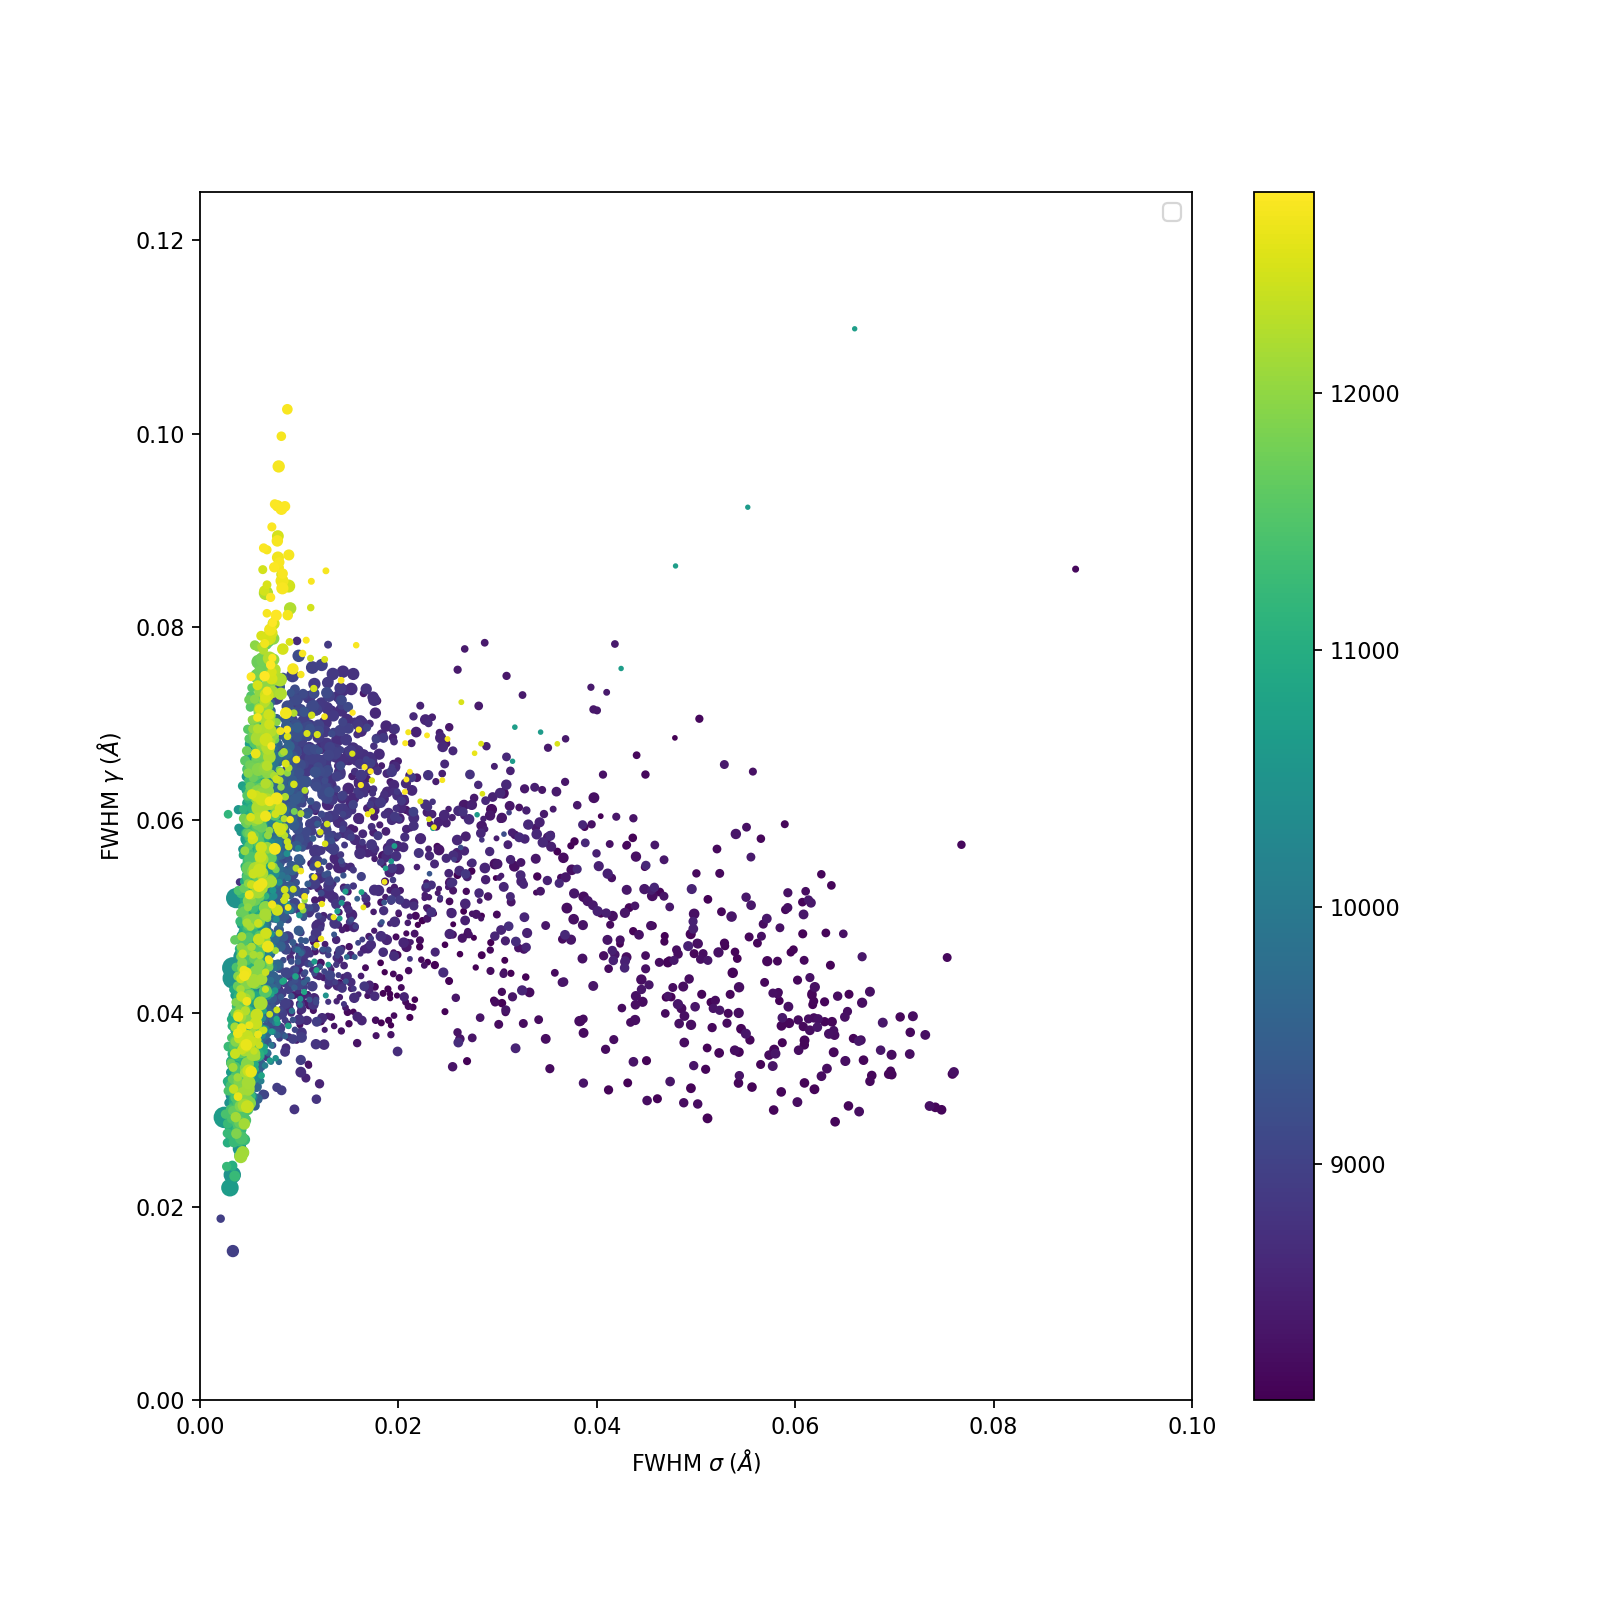

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 0.1)

In [74]:
plt.figure(figsize=(10,10))
cb = plt.scatter(2.355*retrieved_sigmas, 2*retrieved_gammas, s=retrieved_amps*40, c=peak_wavelengths.numpy())

plt.colorbar(cb)
plt.xlabel('FWHM $\sigma \; (\AA)$')
plt.ylabel('FWHM $\gamma \; (\AA)$')
#plt.scatter([2.355*guess_sigma], [2*guess_gamma], marker='*', s=300, color='#bdc3c7', ec='#e74c3c', label='Initial Guess')
plt.legend();
plt.ylim(0,0.125)
plt.xlim(0,0.1)

## Insights

Weird! We find an incompatible locus of posterior parameters--- why?

We have nearly-degenerate families of solutions: you can turn up $\sigma$ and down $\gamma$ (or vice versa) and get about the same answer.  We could/should have instead fit for FWHM and then a shape parameter $(\in 0-1)$.  With that parameterization we would get an exact FWHM constraint, but only a weak constraint on the shape parameter. We may want to do that moving forward!


Even still, it might seem odd that a noise-free spectrum doesn't converge to the exact input, after all there is zero noise added to the input.  Here are some reasons why we still don't get the "right answer":


- We chose Voigt wings that are weak and only manifest near zero flux, where other factors may dominate.  
- Pixel resampling could matter at this level
- The approximations in our implementaiton of the ExoJAX HJERT may be inexact
- The wingcut could matter
- A bug somewhere
- Initial guess matters